Task 1

Pandas is used to process The fake news corpus. Since content will be used for our models we drop any rows that don't have any content.

In [1]:
import re
from collections import Counter
from itertools import chain
import os

import pandas as dp
import modin.config as modin_config
import modin.pandas as mdp
import ray

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import RegexpTokenizer
from cleantext import clean
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from joblib import dump
from sklearn.metrics import accuracy_score

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


We've implemented data processing functions to do the following:

    - Clean the text
    - Tokenize the text
    - Remove stopwords
    - Remove word variations with stemming
We use nltk and cleantext because it has built-in support for many of these operations.
We also use collections to import a counter, sklearn to import functions to split the dataset, chain to help with counting and matplotlib for visualizing.

In [2]:
# ---------------------------
# Global Precompiled Patterns and Instances
# ---------------------------
DATE_PATTERN = re.compile(
    r'([A-Za-z]+\.?\s[0-9]{1,2}?,\s[0-9]{4})|\b\d{4}-\d{2}-\d{2}\b|\b\d{2}-\d{2}-\d{4}\b'
)
TOKENIZER = RegexpTokenizer(r'<\w+>|[\w]+(?:-[\w]+)?')
STOP_WORDS = set(stopwords.words('english'))
PS = PorterStemmer()

# ---------------------------
# Label Mapping for Binary Classification
# ---------------------------

label_mapping = {
    # Omitted "political"
    "reliable": "reliable",
    # Omitted "satire"?
    "hate": "fake",
    "junksci": "fake",
    "clickbait": "fake",
    "rumor": "fake",
    # Omitted "unknown"?
    "unreliable": "fake",
    "conspiracy": "fake",
    "fake": "fake",
    # Omitted bias"?
}

# ---------------------------
# Helper Functions and Plots
# ---------------------------
def build_vocabulary(series: mdp.Series) -> Counter:
    """
    Build a frequency counter from a pandas Series of strings.
    """
    all_tokens = list(chain.from_iterable(series.dropna().str.split()))
    return Counter(all_tokens)

def plot_freq(counter: Counter, top_n: int):
    """
    Plots the frequency of the top_n words using both a line and bar plot.
    """
    common_words = counter.most_common(top_n)
    if not common_words:
        print("No data to plot.")
        return
    words, freqs = zip(*common_words)
    
    plt.figure(figsize=(max(top_n * 0.1, 10), 5))
    plt.xticks(rotation=90, fontsize=5)
    sns.lineplot(x=list(words), y=list(freqs), color='red')
    sns.barplot(x=list(words), y=list(freqs), alpha=0.6)
    plt.title(f'Top {top_n} most common words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

def plot_domain_with_type(df: mdp.DataFrame):
    """
    Plots a stacked bar chart showing the count distribution of news domains by type.
    """
    top_domains = df['domain'].value_counts().head(20).index
    df_filtered = df[df['domain'].isin(top_domains)]
    grouped = df_filtered.groupby(['domain', 'type']).size().unstack(fill_value=0)
    
    grouped.plot(kind='bar', stacked=True, figsize=(10, 5), title='Domain distribution with types')
    plt.show()

def plot_word_frequency(counter: Counter, top_n: int = 10000, title: str = "Word Frequency Distribution"):
    """
    Creates a log-log plot of word frequency distributions.
    """
    freqs = [freq for word, freq in counter.most_common(top_n)]
    
    plt.figure(figsize=(10, 6))
    plt.loglog(range(1, len(freqs) + 1), freqs, marker=".")
    plt.xlabel("Rank of word (log scale)")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()


Task 2

We apply our data processing pipeline from task 1 on the 995k FakeNewsCorpus.

Since Pandas is slow on larger datasets we can use modin and ray to optimize pandas and allow for multithreading.

In [3]:
# ---------------------------
# Data Processing Functions
# ---------------------------

from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline


def clean_text(text: str) -> str:
    """
    Cleans text by replacing dates with a placeholder and using cleantext to:
      - Lowercase text
      - Remove URLs, emails, numbers, currency symbols, punctuation, and line breaks.
    """
    text = DATE_PATTERN.sub('<DATE>', text)
    return clean(
        text,
        lower=True,
        no_urls=True, replace_with_url="<URL>",
        no_emails=True, replace_with_email="<EMAIL>",
        no_numbers=True, replace_with_number="<NUM>",
        no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
        no_punct=True, replace_with_punct="",
        no_line_breaks=True 
    )

def tokenize_text(text: str) -> list:
    """
    Tokenizes input text using a custom regex-based tokenizer and removes stopwords.
    """
    tokens = TOKENIZER.tokenize(text)
    return [token for token in tokens if token not in STOP_WORDS]

def stem_tokens(tokens: list) -> list:
    """
    Applies Porter stemming to a list of tokens.
    """
    return [PS.stem(token) for token in tokens]

def split_dataset(df: mdp.DataFrame):
    """
    Splits the DataFrame into training, validation, and test sets.
    """
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    return train_df, val_df, test_df

def process_pipeline(df: mdp.DataFrame, text_columns) -> mdp.DataFrame:
    """
    Processes the text data by cleaning, tokenizing, and stemming.
    Combines one or more text columns, computes vocabulary statistics,
    and saves intermediate CSV files.
    
    Parameters:
      df (pandas.DataFrame): Input DataFrame.
      text_columns (str or list): Name(s) of the text column(s) to process.
    """
    if isinstance(text_columns, str):
        text_columns = [text_columns]
    
    # Combine the specified text columns into one.
    df['combined_text'] = df[text_columns].apply(lambda row: " ".join(row.dropna().astype(str)), axis=1)
    
    # Clean the combined text.
    df['cleaned_text'] = df['combined_text'].apply(clean_text)
    
    # Tokenize cleaned text and remove stopwords.
    df['tokenized_text'] = df['cleaned_text'].apply(lambda x: " ".join(tokenize_text(x)))
    df.to_csv("combined_tokenized_news_sample.csv", columns=['tokenized_text'], index=False)
    
    # Compute word frequencies.
    original_tokens = list(chain.from_iterable(df['cleaned_text'].str.split()))
    tokenized_tokens = list(chain.from_iterable(df['tokenized_text'].str.split()))
    original_freq = Counter(original_tokens)
    token_freq = Counter(tokenized_tokens)
    
    vocab_original = set(original_tokens)
    vocab_tokenized = set(tokenized_tokens)
    reduction_rate_stopwords = (len(vocab_original) - len(vocab_tokenized)) / len(vocab_original)
    
    print("----- Vocabulary Analysis -----")
    print(f"Original vocabulary size: {len(vocab_original)}")
    print(f"Vocabulary size after stopword removal: {len(vocab_tokenized)}")
    print(f"Reduction rate after stopword removal: {reduction_rate_stopwords:.2%}")
    
    # Apply stemming.
    df['stemmed_text'] = df['tokenized_text'].apply(lambda x: " ".join(stem_tokens(x.split())))
    df.to_csv("combined_stemmed_news_sample.csv", columns=['stemmed_text'], index=False)
    
    stemmed_tokens = list(chain.from_iterable(df['stemmed_text'].str.split()))
    stem_freq = Counter(stemmed_tokens)
    
    reduction_rate_stemming = (len(vocab_tokenized) - len(set(stemmed_tokens))) / len(vocab_tokenized)
    
    print("\n----- Stemming Analysis -----")
    print(f"Vocabulary size after stemming: {len(set(stemmed_tokens))}")
    print(f"Reduction rate after stemming: {reduction_rate_stemming:.2%}")
    
    print("\n----- Top 10 Words -----")
    print(f"Original sample: {original_freq.most_common(10)}")
    print(f"Tokenized sample: {token_freq.most_common(10)}")
    print(f"Stemmed sample: {stem_freq.most_common(10)}")
    
    # Count placeholders.
    url_count = df['stemmed_text'].str.count("<url>").sum()
    date_count = df['stemmed_text'].str.count("<date>").sum()
    num_count = df['stemmed_text'].str.count("<num>").sum()
    
    print("\n----- Placeholder Token Counts -----")
    print(f"Number of URLs: {url_count}")
    print(f"Number of dates: {date_count}")
    print(f"Number of numerics: {num_count}")
    
    # Plot frequency distributions.
    plot_word_frequency(original_freq, title="Original Text Frequency Distribution")
    plot_word_frequency(token_freq, title="Stopword-Removed Frequency Distribution")
    plot_word_frequency(stem_freq, title="Stemmed Frequency Distribution")

    # Plot types
    if 'domain' in df.columns and 'type' in df.columns:
        plot_domain_with_type(df)
    
    if 'type' in df.columns:
        df['type'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(10, 5), title='Types distribution')
        plt.show()
    
    print("\n----- DataFrame Summary -----")
    print(df.info())
    print(df.describe(include="all"))
    
    return df

def load_and_preprocess_data(filepath: str):
    """
    Loads data from a CSV file, drops rows missing critical fields, maps labels, and
    runs the full text processing pipeline.
    """
    df = mdp.read_csv(filepath, encoding="utf-8")
    df = df.dropna(subset=['content', 'title', 'type'])
    
    # Filter rows that have valid types according to our mapping and create a new label column.
    df = df[df['type'].isin(label_mapping.keys())]
    df['label'] = df['type'].map(label_mapping)
    
    # Process text (combining both content and title).
    df = process_pipeline(df, text_columns=['content', 'title'])
    
    return df

def train_logistic_regression(df):
    """
    Splits the data, vectorizes the processed text, trains a logistic regression model,
    prints evaluation metrics, and saves the trained model.
    """
    # Use the 'stemmed_text' column as features and the mapped 'label' column as targets.
    X = df['stemmed_text']
    y = df['label']
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    # Create a pipeline to vectorize and scale the text data.
    vectorizer = CountVectorizer(lowercase=False, max_features=5000, 
                                 token_pattern=r'<[\w]+>|[\w]+')
    pipeline_vectorizer = Pipeline([
         ('vectorizer', vectorizer),
         ('scaler', StandardScaler(with_mean=False))
    ])
    
    X_train_transformed = pipeline_vectorizer.fit_transform(X_train)
    X_val_transformed = pipeline_vectorizer.transform(X_val)
    
    # Train the Logistic Regression model.
    model = LogisticRegression(max_iter=10000, random_state=42)
    model.fit(X_train_transformed, y_train)
    
    # Evaluate the model.
    y_pred = model.predict(X_val_transformed)
    accuracy = accuracy_score(y_val, y_pred)
    # Assuming "fake" is the positive class in our binary labels:
    f1 = f1_score(y_val, y_pred, pos_label="fake")
    print("----- Logistic Regression Results -----")
    print("Accuracy:", accuracy)
    print("F1 score:", f1)
    
    # Save the model along with the vectorizer pipeline.
    dump((model, pipeline_vectorizer), 'models/simple_model_content.joblib')
    print("Model saved to 'models/simple_model_content.joblib'")

In [4]:
# ---------------------------
# Task 1: Fake News Corpus Sample Processing
# ---------------------------
def task1():
    """
    Reads a small fake news sample from a URL, builds vocabularies for
    content and title, plots frequency distributions, and shows domain/type plots.
    """
    url = 'Datasets/news_sample.csv'
    df = mdp.read_csv(url)
    
    # Drop rows without content.
    df = df.dropna(subset=['content'])
    print("Task 1: First few rows of the dataset:")
    print(df.head())
    
    vocab_content = build_vocabulary(df['content'])
    vocab_title = build_vocabulary(df['title'])
    
    print("Numerics in content: ", vocab_content.get("<num>", 0))
    plot_freq(vocab_content, 100)
    
    print("Numerics in titles: ", vocab_title.get("<num>", 0))
    plot_freq(vocab_title, 100)
    
    dfcpy = df.dropna(subset=['content', 'title', 'type'])
    print(f"Number of dropped rows: {df.shape[0] - dfcpy.shape[0]}")

def pipeline(path):
    """
    Runs the full data processing pipeline on a small sample (300 rows)
    of the fake news corpus stored locally.
    """
    sample_path = path  # Adjust this path as needed.
    try:
        df = mdp.read_csv(sample_path, encoding="utf-8")
    except Exception as e:
        print("Error reading sample CSV:", e)
        return
    df_sample = df.head(300).copy()
    process_pipeline(df_sample, text_columns='content')

In [5]:
# ---------------------------
# Task 2: Processing 995k Rows Using Modin and Ray
# ---------------------------
def task2():
    """
    Applies the data processing pipeline to a large 995k-row dataset using Modin
    and Ray for parallelized operations. After processing, the cleaned DataFrame is saved.
    """
    file_path = "Datasets/995000_rows.csv"  # Adjust the file path as needed.
    try:
        df_modin = mdp.read_csv(
            file_path, 
            usecols=['content', 'type', 'title', 'domain'], 
            engine='c', 
            dtype=str
        )
    except Exception as e:
        print("Error reading 995k CSV:", e)
        return
    
    # Drop rows with missing critical data.
    df_modin = df_modin.dropna(subset=['content', 'type', 'title'])
    
    # Process pipeline on a copy for demonstration.
    process_pipeline(df_modin.head(300).copy(), text_columns=list(df_modin.columns))
    
    # Clean extra white spaces using vectorized string methods.
    df_modin['content'] = df_modin['content'].str.split().str.join(" ")
    df_modin['title'] = df_modin['title'].str.split().str.join(" ")
    
    df_modin.to_csv('Datasets/995k_rows_cleaned.csv', index=False)
    print("Done cleaning the data.")

2025-03-13 00:35:57,443	INFO worker.py:1841 -- Started a local Ray instance.


Executing Task 1: Data Exploration and Vocabulary Analysis


Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


Task 1: First few rows of the dataset:
   Unnamed: 0   id                domain        type  \
0           0  141               awm.com  unreliable   
1           1  256     beforeitsnews.com        fake   
2           2  700           cnnnext.com  unreliable   
3           3  768               awm.com  unreliable   
4           4  791  bipartisanreport.com   clickbait   

                                                 url  \
0  http://awm.com/church-congregation-brings-gift...   
1  http://beforeitsnews.com/awakening-start-here/...   
2  http://www.cnnnext.com/video/18526/never-hike-...   
3  http://awm.com/elusive-alien-of-the-sea-caught...   
4  http://bipartisanreport.com/2018/01/21/trumps-...   

                                             content  \
0  Sometimes the power of Christmas will make you...   
1  AWAKENING OF 12 STRANDS of DNA – “Reconnecting...   
2  Never Hike Alone: A Friday the 13th Fan Film U...   
3  When a rare shark was caught, scientists were ...   
4  Dona

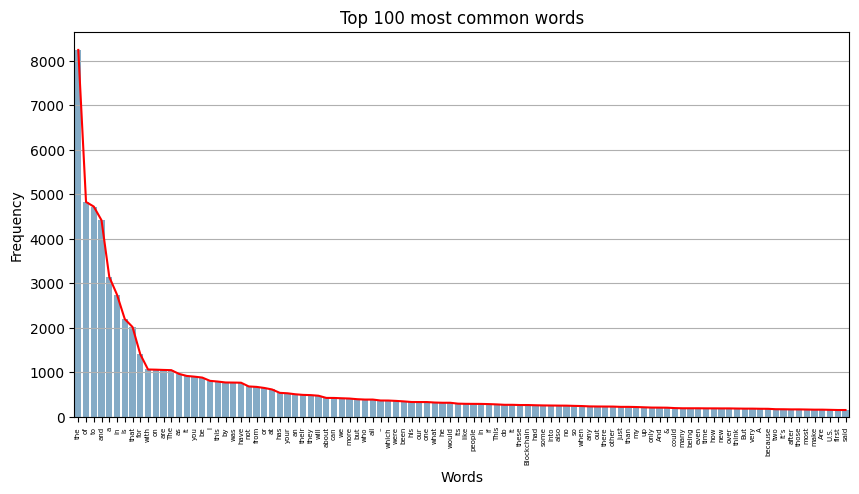

Numerics in titles:  0


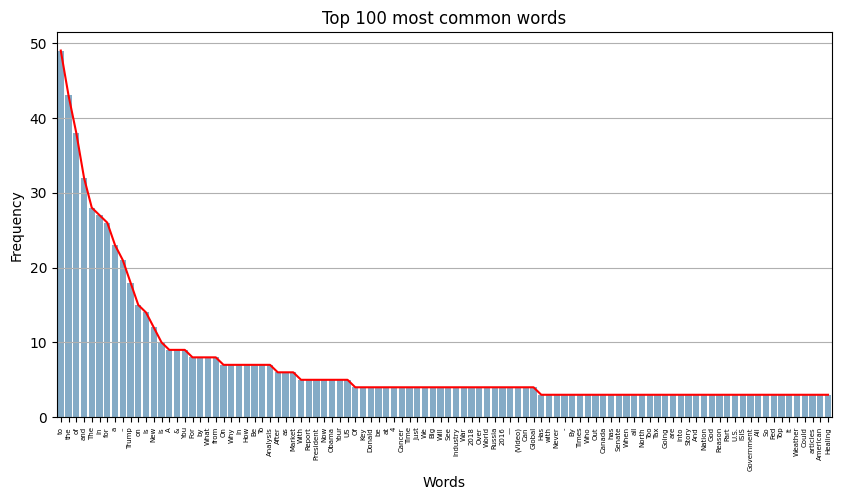

Number of dropped rows: 12

Executing Task 1 Pipeline on a Sample


(_remote_exec_multi_chain pid=31224) Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


----- Vocabulary Analysis -----
Original vocabulary size: 16674
Vocabulary size after stopword removal: 16462
Reduction rate after stopword removal: 1.27%

----- Stemming Analysis -----
Vocabulary size after stemming: 11048
Reduction rate after stemming: 32.89%

----- Top 10 Words -----
Original sample: [('the', 9487), ('of', 4965), ('to', 4888), ('and', 4697), ('a', 3379), ('in', 3108), ('is', 2317), ('that', 2203), ('<num>', 1573), ('for', 1552)]
Tokenized sample: [('<num>', 2170), ('us', 447), ('one', 423), ('people', 368), ('like', 327), ('would', 321), ('trump', 301), ('time', 291), ('also', 276), ('new', 270)]
Stemmed sample: [('<num>', 2170), ('one', 463), ('us', 447), ('like', 406), ('time', 393), ('peopl', 387), ('state', 366), ('trump', 348), ('use', 322), ('would', 321)]

----- Placeholder Token Counts -----
Number of URLs: 243
Number of dates: 104
Number of numerics: 2170


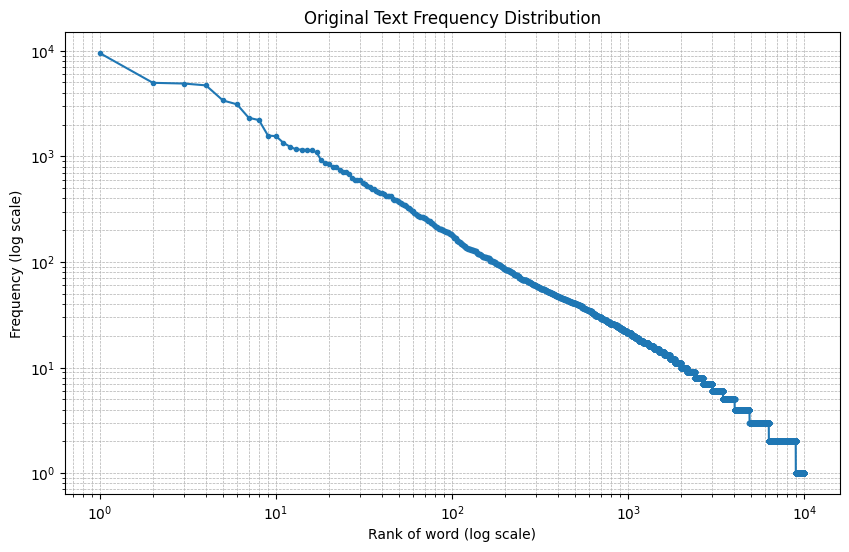

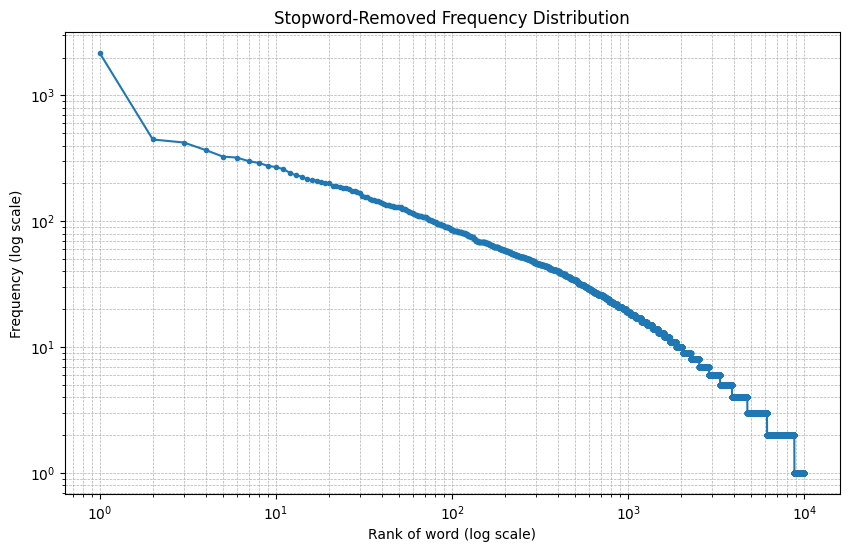

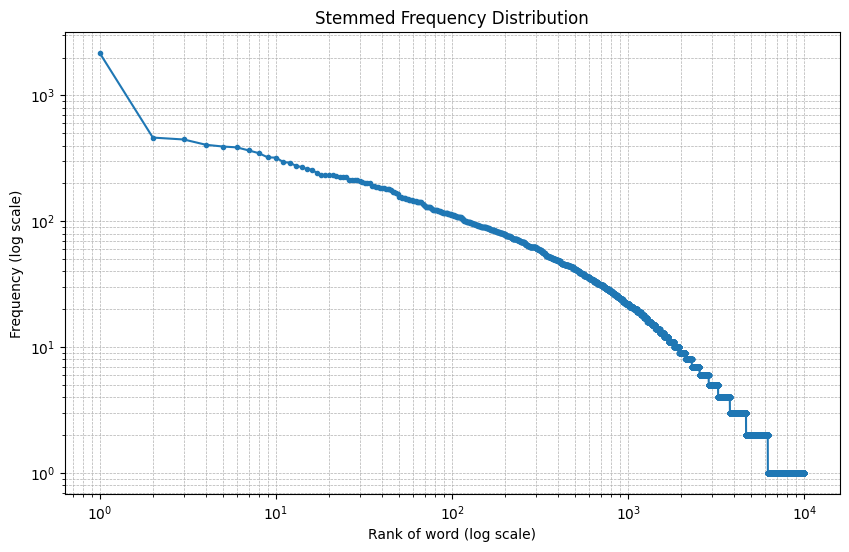

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.
(remote_exec_func pid=27556) FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.


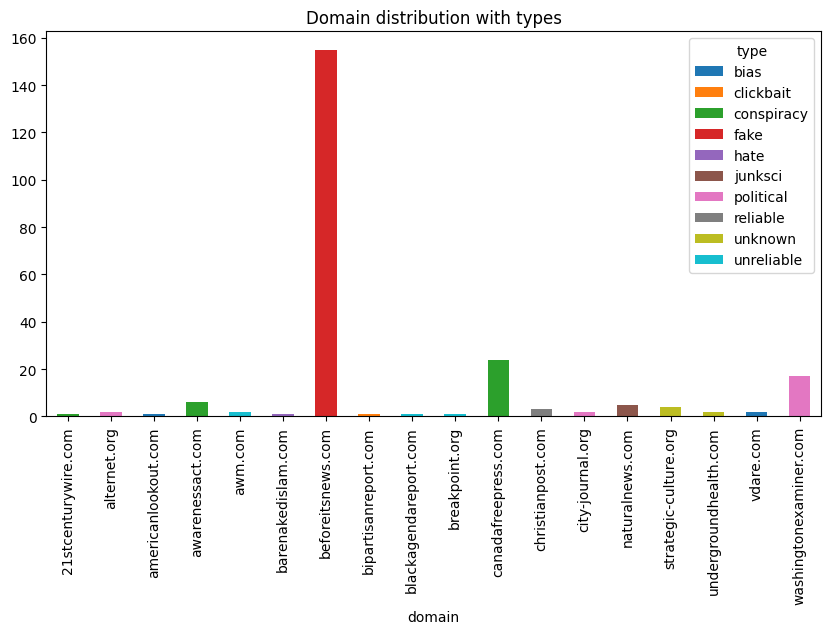

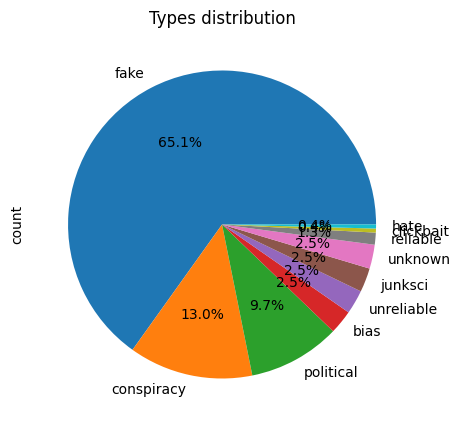


----- DataFrame Summary -----
<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        250 non-null    int64  
 1   id                250 non-null    int64  
 2   domain            250 non-null    object 
 3   type              238 non-null    object 
 4   url               250 non-null    object 
 5   content           250 non-null    object 
 6   scraped_at        250 non-null    object 
 7   inserted_at       250 non-null    object 
 8   updated_at        250 non-null    object 
 9   title             250 non-null    object 
 10  authors           170 non-null    object 
 11  keywords          0 non-null      float64
 12  meta_keywords     250 non-null    object 
 13  meta_description  54 non-null     object 
 14  tags              27 non-null     object 
 15  summary           0 non-null      float64
 16  combined

(_remote_exec_single_chain pid=27556) Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results. [repeated 29x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


----- Vocabulary Analysis -----
Original vocabulary size: 17589
Vocabulary size after stopword removal: 17371
Reduction rate after stopword removal: 1.24%

----- Stemming Analysis -----
Vocabulary size after stemming: 12276
Reduction rate after stemming: 29.33%

----- Top 10 Words -----
Original sample: [('the', 9249), ('of', 4513), ('to', 4362), ('and', 3898), ('a', 3490), ('in', 2968), ('<num>', 2346), ('that', 1900), ('is', 1606), ('for', 1468)]
Tokenized sample: [('<num>', 3854), ('said', 492), ('one', 375), ('new', 336), ('people', 331), ('us', 318), ('would', 307), ('<cur>', 239), ('also', 236), ('mr', 235)]
Stemmed sample: [('<num>', 3854), ('said', 492), ('one', 401), ('state', 382), ('peopl', 350), ('new', 336), ('us', 318), ('time', 307), ('would', 307), ('year', 275)]

----- Placeholder Token Counts -----
Number of URLs: 78
Number of dates: 128
Number of numerics: 3854


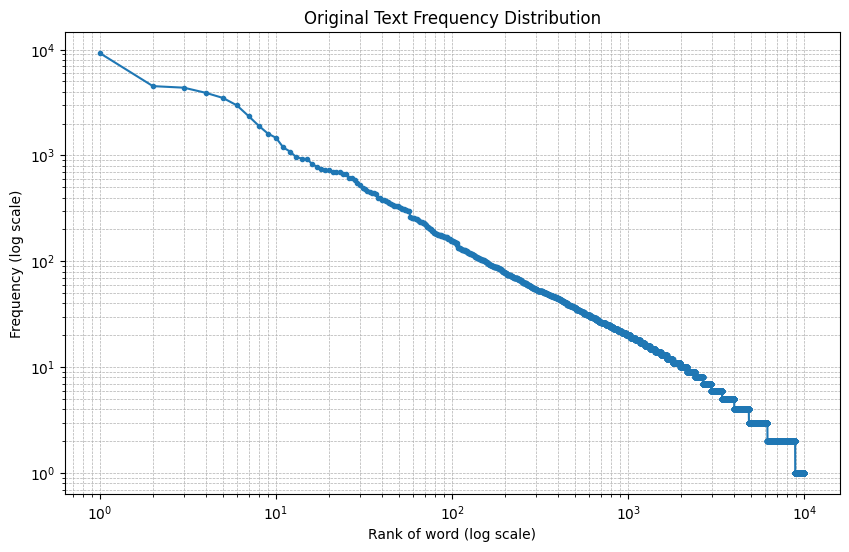

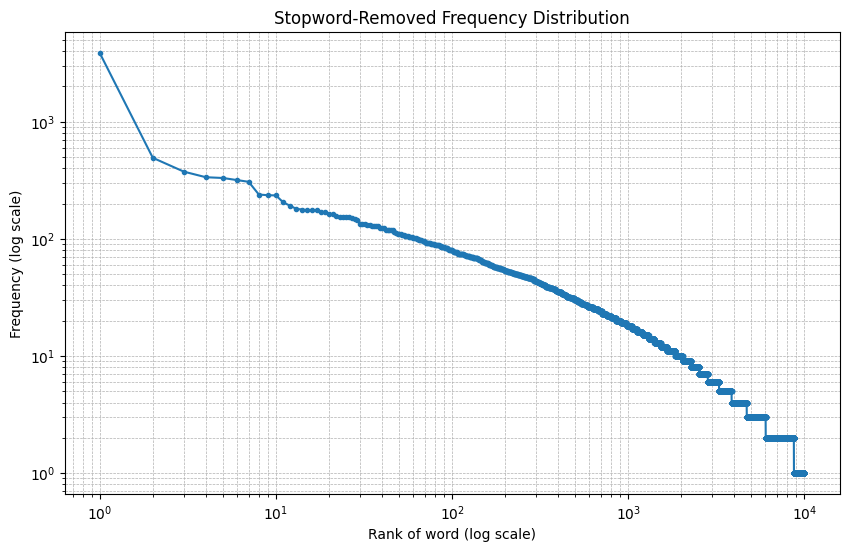

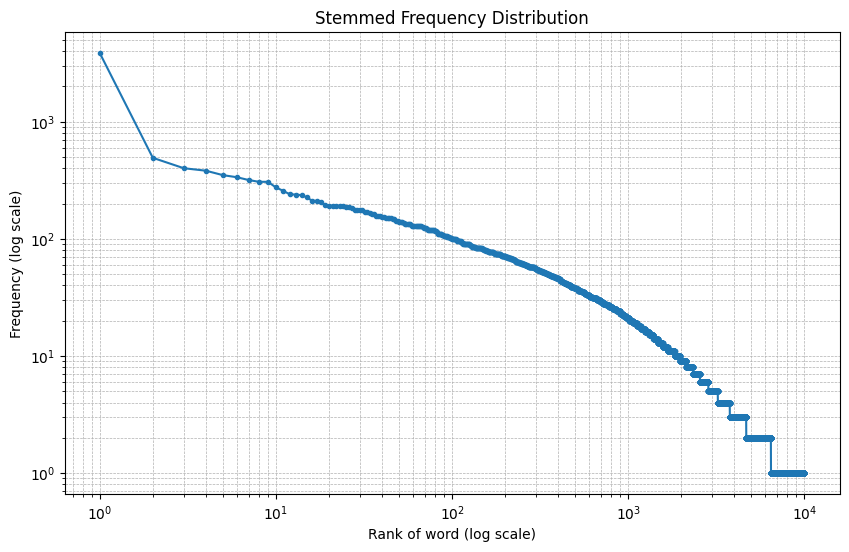

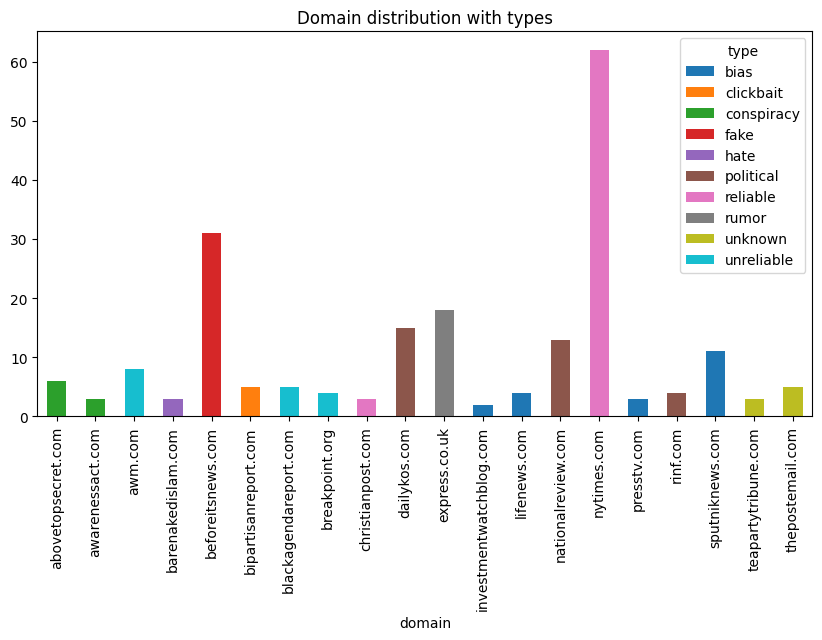

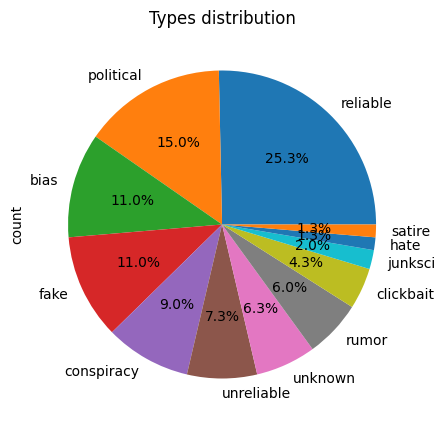


----- DataFrame Summary -----
<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   domain          300 non-null    object
 1   type            300 non-null    object
 2   content         300 non-null    object
 3   title           300 non-null    object
 4   combined_text   300 non-null    object
 5   cleaned_text    300 non-null    object
 6   tokenized_text  300 non-null    object
 7   stemmed_text    300 non-null    object
dtypes: object(8)
memory usage: 18.9+ KB
None
             domain      type  \
count           300       300   
unique           97        12   
top     nytimes.com  reliable   
freq             62        76   

                                                  content               title  \
count                                                 300                 300   
unique                                        

(remote_exec_func pid=43420) FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version. [repeated 7x across cluster]


----- Vocabulary Analysis -----
Original vocabulary size: 14657
Vocabulary size after stopword removal: 14453
Reduction rate after stopword removal: 1.39%

----- Stemming Analysis -----
Vocabulary size after stemming: 9835
Reduction rate after stemming: 31.95%

----- Top 10 Words -----
Original sample: [('the', 7408), ('of', 3977), ('and', 3818), ('to', 3769), ('a', 2672), ('in', 2436), ('is', 1748), ('that', 1679), ('<num>', 1386), ('for', 1236)]
Tokenized sample: [('<num>', 1907), ('us', 332), ('one', 331), ('people', 268), ('like', 266), ('blockchain', 260), ('would', 257), ('trump', 247), ('<url>', 241), ('time', 234)]
Stemmed sample: [('<num>', 1907), ('one', 355), ('us', 332), ('like', 328), ('time', 312), ('market', 285), ('peopl', 281), ('trump', 278), ('state', 277), ('blockchain', 260)]

----- Placeholder Token Counts -----
Number of URLs: 241
Number of dates: 85
Number of numerics: 1907


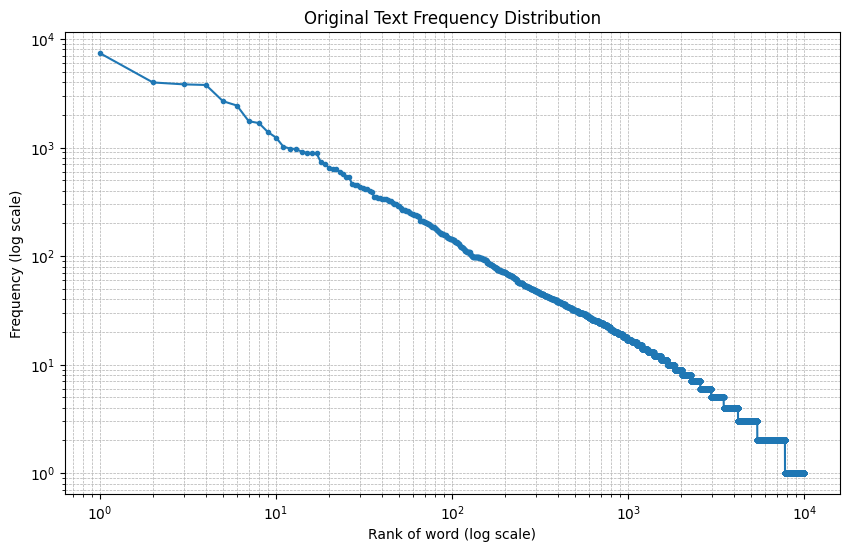

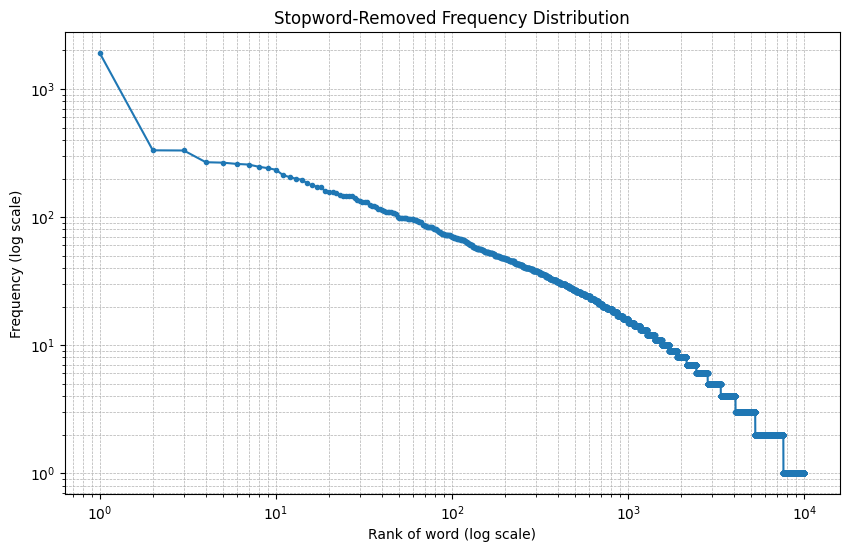

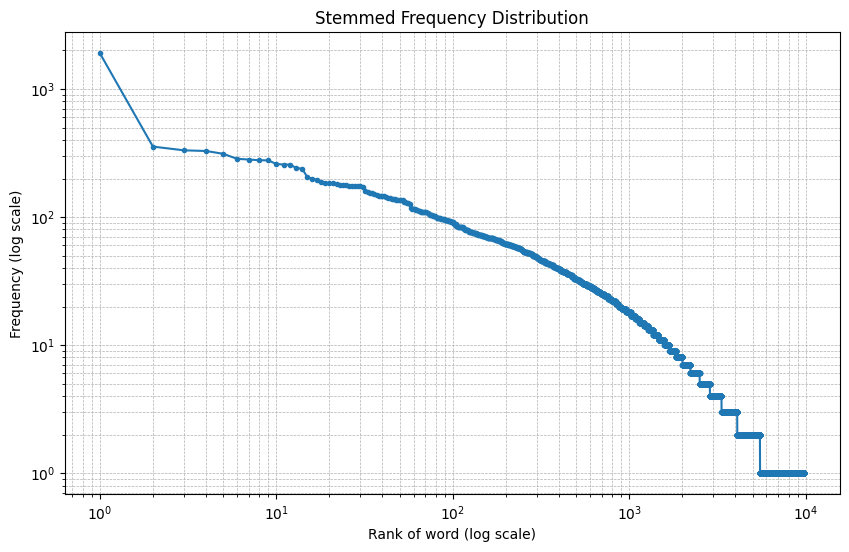

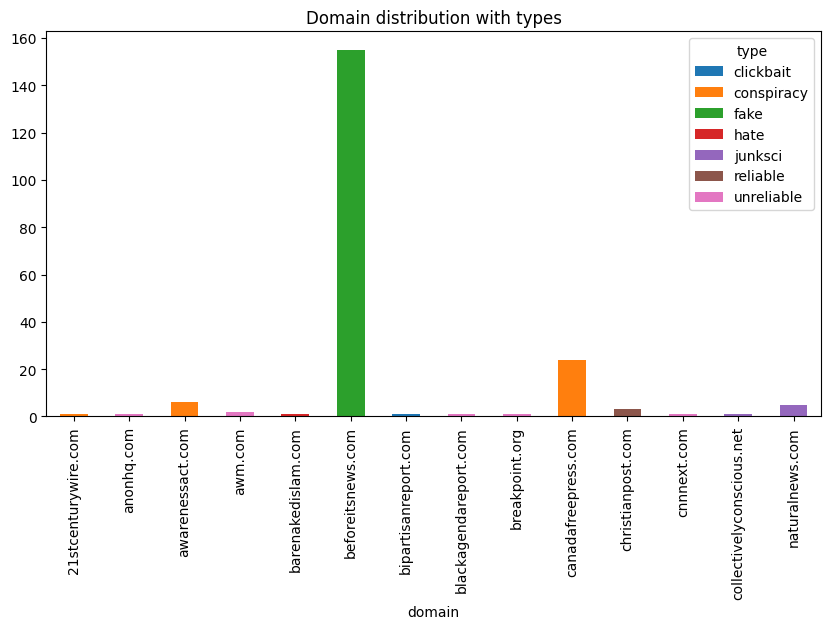

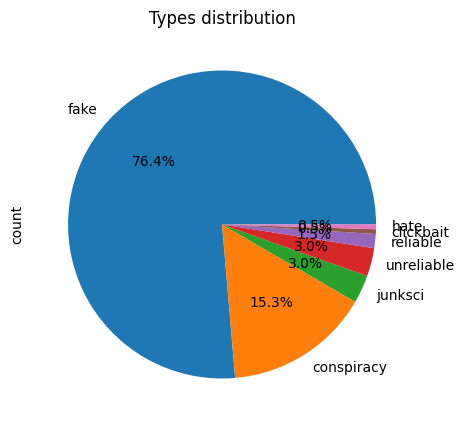


----- DataFrame Summary -----
<class 'modin.pandas.dataframe.DataFrame'>
Index: 203 entries, 0 to 246
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        203 non-null    int64  
 1   id                203 non-null    int64  
 2   domain            203 non-null    object 
 3   type              203 non-null    object 
 4   url               203 non-null    object 
 5   content           203 non-null    object 
 6   scraped_at        203 non-null    object 
 7   inserted_at       203 non-null    object 
 8   updated_at        203 non-null    object 
 9   title             203 non-null    object 
 10  authors           143 non-null    object 
 11  keywords          0 non-null      float64
 12  meta_keywords     203 non-null    object 
 13  meta_description  14 non-null     object 
 14  tags              12 non-null     object 
 15  summary           0 non-null      float64
 16  label        

(_remote_exec_multi_chain pid=43420) Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results. [repeated 2x across cluster]


In [6]:
# ---------------------------
# Main Execution
# ---------------------------

if __name__ == "__main__":
    modin_config.Engine.put("ray")    
    ray.shutdown()
    ray.init(ignore_reinit_error=True)
    print("Executing Task 1: Data Exploration and Vocabulary Analysis")
    task1()

    
    print("\nExecuting Task 1 Pipeline on a Sample")
    pipeline("Datasets/news_sample.csv")

    
    if not "995k_rows_cleaned.csv" in os.listdir("Datasets"):
        print("\nExecuting Task 2: Processing with Modin and Ray")
        task2()

    
    print("\nExecuting Task 2 Pipeline on the Full Dataset")
    pipeline("Datasets/995k_rows_cleaned.csv")

    print("\nload and preprocess data")
    df = load_and_preprocess_data("Datasets/news_sample.csv")
    print("\n train logistic regression")
    train_logistic_regression(df)

    print("\n\n\n\n\n\n\nAll tasks completed.")
    ray.shutdown()

